In [1]:
import os
import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
from torchvision.datasets import ImageFolder, DatasetFolder

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, accuracy_score
from sklearn.model_selection import train_test_split

from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from tqdm import trange

from matplotlib import pyplot as plt
from pathlib import Path
from PIL import Image
from copy import copy

import numpy as np
%load_ext autotime

time: 163 µs (started: 2021-01-28 15:51:48 +07:00)


In [3]:
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)
input_size = 224
batch_size = 32
data_transforms = transforms.Compose([
    transforms.Resize(input_size),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

time: 1.27 ms (started: 2021-01-28 15:51:57 +07:00)


### God damn the ImageFolder, not working when changing labels. Must write custom Dataset now

In [33]:
# train_ds = ImageFolder('./training_dataset', transform=data_transforms)
# train_ds.targets = torch.tensor(train_ds.targets)
# train_ds.targets = train_ds.targets==2
# train_ds.targets = train_ds.targets.float()

# test_ds = ImageFolder('./test_dataset', transform=data_transforms)
# train, val = random_split(train_ds, [1900, 100])

# train_dl = DataLoader(train, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=2)
# val_dl = DataLoader(val, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=2)
# test_dl = DataLoader(test_ds, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=2)

time: 573 µs (started: 2021-01-28 11:16:37 +07:00)


In [4]:
class ImageData(Dataset):
    def __init__(self, root, transform):
        self.X = []
        self.y = []
        self.transform = transform
        for image_file in Path(root).glob("**/*.png"):
            self.X.append(
                self.transform(Image.open(str(image_file)))
            )
            if "not" in str(image_file):
                self.y.append(0)
            else:
                self.y.append(1)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return (self.X[idx], self.y[idx])

time: 1.52 ms (started: 2021-01-28 15:52:00 +07:00)


In [5]:
train_ds = ImageData('./training_dataset', transform=data_transforms)

test_ds = ImageData('./test_dataset', transform=data_transforms)
train, val = random_split(train_ds, [1900, 100])

train_dl = DataLoader(train, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=2)
val_dl = DataLoader(val, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=2)
test_dl = DataLoader(test_ds, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=2)

time: 2.02 s (started: 2021-01-28 15:52:00 +07:00)


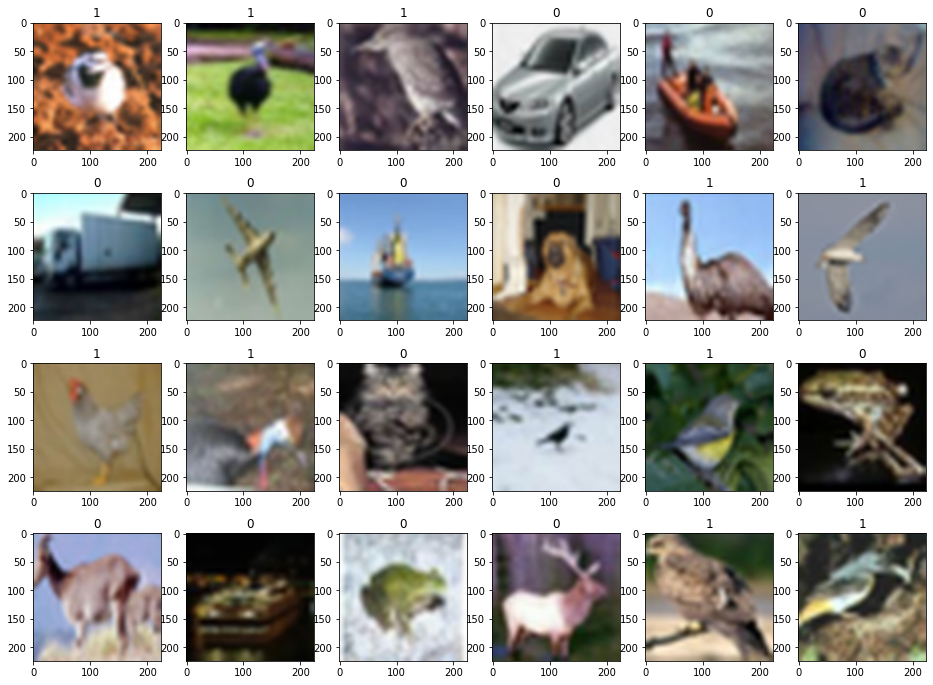

time: 3.37 s (started: 2021-01-28 15:52:04 +07:00)


In [6]:
def inverse_normalize(tensor, mean, std):
    for t, m, s in zip(tensor, mean, std):
        t.mul_(s).add_(m)
    return tensor

images, labels = next(iter(train_dl))
fig = plt.figure(figsize=(16, 12))

columns = 6
rows = 4

ax = []

for i in range(columns*rows):
    npimg = inverse_normalize(images[i], mean, std).numpy()
    label = labels[i].numpy()
    ax.append(fig.add_subplot(rows, columns, i + 1))
    ax[-1].set_title(label)
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

plt.show()

In [57]:
# Densenet
device = 'cuda'
batch_size = 32
input_size = 224

model = models.densenet121(pretrained=True)
num_ftrs = model.classifier.in_features

for param in model.parameters():
    param.requires_grad = False

model.classifier = nn.Sequential(
    nn.Linear(num_ftrs, 128),
    nn.Sigmoid()
).to(device)

RuntimeError: CUDA error: device-side assert triggered

time: 201 ms (started: 2021-01-28 15:48:52 +07:00)


In [7]:
# Resnet
device = 'cuda'
batch_size = 32
input_size = 224

model = models.resnet18(pretrained=True)
for param in model.parameters():
    param.requires_grad = False

num_ftrs = model.fc.in_features
model.fc = nn.Sequential(
    nn.Linear(num_ftrs, 128),
    nn.ReLU(inplace=True),
    nn.Linear(512, 128),
    nn.ReLU(inplace=True),
    nn.Linear(128, 1),
    nn.Sigmoid()
)

time: 188 ms (started: 2021-01-28 15:52:17 +07:00)


In [11]:
model = model.to(device)
opt = torch.optim.Adam(model.parameters())
loss_fn = nn.BCELoss()
losses = []
accuracies = []

with trange(15) as t:
    for i in t:
        for inputs, labels in train_dl:
            labels = labels.unsqueeze(1)
            labels = labels.float()
            inputs, labels = inputs.to(device), labels.to(device)
            opt.zero_grad()
            outputs = model(inputs)
            loss = loss_fn(outputs, labels)
            loss.backward()
            opt.step()
        with torch.no_grad():
            for X_val, y_val in val_dl:
                X_val, y_val = X_val.to(device), y_val.to(device)
                y_preds = model(X_val)
                y_preds = y_preds >= 0.7
                y_val = y_val > 0
                acc = accuracy_score(
                    y_preds.cpu().data.numpy(), 
                    y_val.cpu().data.numpy(), 
                )
                accuracies.append(acc)
        losses.append(loss.item())
        t.set_description(f"Loss: {loss:.4f} Accuracy: {np.mean(accuracies):.4f}")

  0%|          | 0/15 [00:00<?, ?it/s]


torch.Size([32, 3, 224, 224])


RuntimeError: mat1 dim 1 must match mat2 dim 0

time: 210 ms (started: 2021-01-28 15:53:09 +07:00)


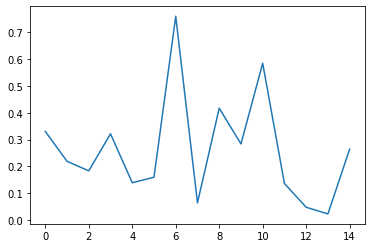

time: 102 ms (started: 2021-01-28 15:36:03 +07:00)


In [33]:
plt.plot(losses)

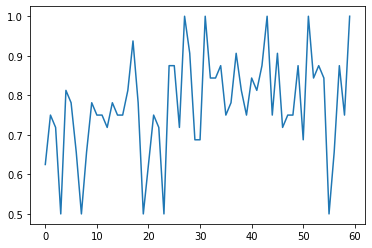

time: 87.6 ms (started: 2021-01-28 15:38:48 +07:00)


In [43]:
plt.plot(accuracies)

In [48]:
correct = 0
total = 0
model.eval()

with torch.no_grad():
    for data in test_dl:
        images, labels = data
        images, labels = images.to('cpu'), labels.to('cpu')
        outputs = model(images)
        preds = outputs >= 0.5
        y_test = labels == 1
        correct += accuracy_score(
            preds.cpu().data.numpy(), 
            y_test.cpu().data.numpy(), 
            normalize=False
        )
        total += labels.size(0)

print('Accuracy of the network on the 10000 test images: %d %%' % (correct * 100 / total))

torch.Size([32, 3, 224, 224]) torch.Size([32])


RuntimeError: mat1 and mat2 shapes cannot be multiplied (32x1 and 512x128)

time: 656 ms (started: 2021-01-28 15:44:11 +07:00)


In [36]:
model2 = copy(model)
model2.to('cpu')
images = []

for f in sorted(Path(".").glob("*.png")):
    img_file = Image.open(str(f))
    img = data_transforms(img_file)
    img = img.unsqueeze(0)
    confidence = model2(img).item()
    if confidence > 0.5:  
        print(f'{f} - Is a bird {int(confidence * 100)}%')
    else:
        print(f'{f} - Is NOT a bird {100 - int(confidence * 100)}%')
    images.append((img_file, confidence))

bird_1.png - Is a bird 51%
bird_2.png - Is a bird 52%
bird_3.png - Is a bird 52%
not_bird_1.png - Is a bird 54%
not_bird_2.png - Is a bird 55%
not_bird_3.png - Is a bird 53%
time: 227 ms (started: 2021-01-28 15:36:12 +07:00)
